In [1]:
# Usar ambiente SMNAMonitoringApp

import os
import zarr
import intake
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
config = {}
variables = {}

def parse_ctl_file(filein_ctl):
    with open(filein_ctl, 'r') as f:
        linhas = f.readlines()

    ler_variaveis = False

    for linha in linhas:
        linha = linha.strip()

        if linha.lower().startswith('dset'):
            config['dset'] = linha.split('^')[-1].strip()

        elif linha.lower().startswith('options'):
            config['options'] = linha.split()[1:]

        elif linha.lower().startswith('undef'):
            config['undef'] = float(linha.split()[1])

        elif linha.lower().startswith('xdef'):
            partes = linha.split()
            config['xdef'] = {
                'num': int(partes[1]),
                'type': partes[2],
                'start': float(partes[3]),
                'increment': float(partes[4])
            }

        elif linha.lower().startswith('ydef'):
            partes = linha.split()
            config['ydef'] = {
                'num': int(partes[1]),
                'type': partes[2],
                'start': float(partes[3]),
                'increment': float(partes[4])
            }

        elif linha.lower().startswith('zdef'):
            partes = linha.split()
            config['zdef'] = {
                'num': int(partes[1]),
                'type': partes[2],
                'start': float(partes[3]),
                'increment': float(partes[4])
            }

        elif linha.lower().startswith('tdef'):
            partes = linha.split()
            config['tdef'] = {
                'num': int(partes[1]),
                'type': partes[2],
                'start_time': partes[3],
                'increment': partes[4]
            }

        elif linha.lower().startswith('vars'):
            ler_variaveis = True
            num_vars = int(linha.split()[1])
            config['nvars'] = num_vars

        elif linha.lower().startswith('endvars'):
            ler_variaveis = False

        elif ler_variaveis and linha != '':
            partes = linha.split(maxsplit=3)
            varinfo = {
                'name': partes[0],
                'level': int(partes[1]),
                'code': int(partes[2]),
                'description': partes[3]
            }
            #varinfo2 = {str(partes[0]): str(partes[3])}
            #variables.append(varinfo2)
            variables[str(partes[0])] = str(partes[3])

    return config, variables

In [3]:
Regs = ['gl', 'hn', 'tr', 'hs', 'as']
#Regs = ['hs']
FStats = ['VIES', 'RMSE', 'MEAN']
TStats = ['VIES', 'RMSE', 'ACOR']

bpath = '/extra2/Lucas/SCANTEC'

date_range = '20240715002024081500'

dtype = np.float32

In [4]:
config, variables = parse_ctl_file('/extra2/Lucas/SCANTEC/gl/RMSEEXP01_'+ str(date_range) + 'F.ctl')

In [5]:
def read_scantec_binary(fnamein_bin, fnamein_ctl, reg):#, nx, ny, delta, npts):
    with open(fnamein_bin, 'rb') as f:
        
        config, variables = parse_ctl_file(fnamein_ctl)
        
        #n_times = config['tdef']['num']
        n_times = 10
        n_vars = config['nvars']
        ny = config['ydef']['num']
        nx = config['xdef']['num']
        delta = config['xdef']['increment']
        npts = ny * nx
        lat_start = config['xdef']['start']
        lon_start = config['ydef']['start']
        lons = np.linspace(lon_start, lon_start + (nx-1)*delta, nx)
        lats = np.linspace(lat_start, lat_start + (ny-1)*delta, ny)
        var_names = variables.keys()        
        
        #n_times, n_vars, ny, nx, delta, npts, variables = get_dims(filein_ctl)
        data = np.empty((n_times, n_vars, ny, nx), dtype=dtype)
        
        start_date = pd.Timestamp('2024-09-15 00:00:00')
        times = pd.date_range(start=start_date, periods=n_times, freq='D')
        #lats, lons = get_lat_lon(reg, nx, ny, delta)
        
        for t in range(n_times):
            for v in range(n_vars):
                rec_start = np.fromfile(f, dtype=np.int32, count=1)
                temp = np.fromfile(f, dtype=dtype, count=npts)
                #print(f"Tempo {t}, Var {v}: leu {temp.size} elementos")
                temp = temp.reshape((ny, nx))
                data[t, v, :, :] = temp
                rec_end = np.fromfile(f, dtype=np.int32, count=1)

                if rec_start[0] != rec_end[0]:
                    print(f"Aviso: record markers diferentes no tempo {t}, variável {v}")

    ds = xr.Dataset({name: (('time', 'lat', 'lon'), data[:, i, :, :]) for i, name in enumerate(var_names)}, coords={'time': times, 'lat': lats, 'lon': lons})

    return ds

In [6]:
%%time

# Escrita convencional, formato zarr (1 arquivos por vez)

for reg in Regs:
    for stat in FStats:
        filein_bin = str(stat) + 'EXP01_' + date_range + 'F.scan'
        filein_ctl = str(stat) + 'EXP01_' + date_range + 'F.ctl'
        
        fnamein_bin = os.path.join(bpath, reg, filein_bin)
        fnamein_ctl = os.path.join(bpath, reg, filein_ctl)
               
        fileout = str(stat) + 'EXP01_' + date_range + 'F.zarr'
        fnameout_zarr = os.path.join(bpath, reg, fileout)

        print(fnamein_bin, fnamein_ctl, fnameout_zarr, stat, reg)
        
        dset = read_scantec_binary(fnamein_bin, fnamein_ctl, reg)
        
        dset.to_zarr(fnameout_zarr, mode='w', consolidated=True)

/extra2/Lucas/SCANTEC/gl/VIESEXP01_20240715002024081500F.scan /extra2/Lucas/SCANTEC/gl/VIESEXP01_20240715002024081500F.ctl /extra2/Lucas/SCANTEC/gl/VIESEXP01_20240715002024081500F.zarr VIES gl
/extra2/Lucas/SCANTEC/gl/RMSEEXP01_20240715002024081500F.scan /extra2/Lucas/SCANTEC/gl/RMSEEXP01_20240715002024081500F.ctl /extra2/Lucas/SCANTEC/gl/RMSEEXP01_20240715002024081500F.zarr RMSE gl
/extra2/Lucas/SCANTEC/gl/MEANEXP01_20240715002024081500F.scan /extra2/Lucas/SCANTEC/gl/MEANEXP01_20240715002024081500F.ctl /extra2/Lucas/SCANTEC/gl/MEANEXP01_20240715002024081500F.zarr MEAN gl
/extra2/Lucas/SCANTEC/hn/VIESEXP01_20240715002024081500F.scan /extra2/Lucas/SCANTEC/hn/VIESEXP01_20240715002024081500F.ctl /extra2/Lucas/SCANTEC/hn/VIESEXP01_20240715002024081500F.zarr VIES hn
/extra2/Lucas/SCANTEC/hn/RMSEEXP01_20240715002024081500F.scan /extra2/Lucas/SCANTEC/hn/RMSEEXP01_20240715002024081500F.ctl /extra2/Lucas/SCANTEC/hn/RMSEEXP01_20240715002024081500F.zarr RMSE hn
/extra2/Lucas/SCANTEC/hn/MEANEXP01_

In [7]:
# Teste de abertura do arquivo zarr escrito

ds = xr.open_zarr('/extra2/Lucas/SCANTEC/gl/MEANEXP01_'+ str(date_range) + 'F.zarr')

In [8]:
ds

<xarray.Dataset> Size: 289MB
Dimensions:  (time: 10, lat: 401, lon: 901)
Coordinates:
  * lat      (lat) float64 3kB 0.0 0.4 0.8 1.2 1.6 ... 158.8 159.2 159.6 160.0
  * lon      (lon) float64 7kB -80.0 -79.6 -79.2 -78.8 ... 279.2 279.6 280.0
  * time     (time) datetime64[ns] 80B 2024-09-15 2024-09-16 ... 2024-09-24
Data variables: (12/20)
    agpl925  (time, lat, lon) float32 14MB dask.array<chunksize=(3, 101, 451), meta=np.ndarray>
    psnm000  (time, lat, lon) float32 14MB dask.array<chunksize=(3, 101, 451), meta=np.ndarray>
    temp250  (time, lat, lon) float32 14MB dask.array<chunksize=(3, 101, 451), meta=np.ndarray>
    temp500  (time, lat, lon) float32 14MB dask.array<chunksize=(3, 101, 451), meta=np.ndarray>
    temp850  (time, lat, lon) float32 14MB dask.array<chunksize=(3, 101, 451), meta=np.ndarray>
    umes500  (time, lat, lon) float32 14MB dask.array<chunksize=(3, 101, 451), meta=np.ndarray>
    ...       ...
    vvel250  (time, lat, lon) float32 14MB dask.array<chunksize=(3, 101, 451), meta=np.ndarray>
    vvel500  (time, lat, lon) float32 14MB dask.array<chunksize=(3, 101, 451), meta=np.ndarray>
    vvel850  (time, lat, lon) float32 14MB dask.array<chunksize=(3, 101, 451), meta=np.ndarray>
    zgeo250  (time, lat, lon) float32 14MB dask.array<chunksize=(3, 101, 451), meta=np.ndarray>
    zgeo500  (time, lat, lon) float32 14MB dask.array<chunksize=(3, 101, 451), meta=np.ndarray>
    zgeo850  (time, lat, lon) float32 14MB dask.array<chunksize=(3, 101, 451), meta=np.ndarray>

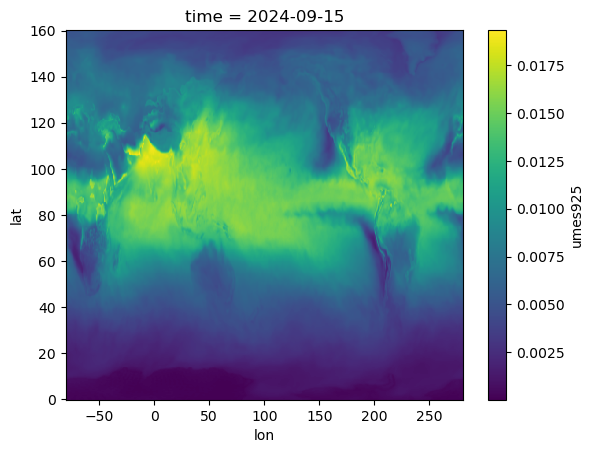

In [9]:
ds['umes925'].isel(time=0).plot()

In [10]:
%%time

df_dic = {}

for reg in Regs:
    for stat in TStats:
        filein = str(stat) + 'EXP01_' + date_range + 'T.scan'
        fnamein = os.path.join(bpath, reg, filein)
        fileout = str(stat) + 'EXP01_' + date_range + 'T.csv'
        fnameout = os.path.join(bpath, reg, fileout)
        print(fnamein, fnameout, stat, reg)
        df = pd.read_csv(fnamein, sep=r"\s+")
        df.to_csv(fnameout)

/extra2/Lucas/SCANTEC/gl/VIESEXP01_20240715002024081500T.scan /extra2/Lucas/SCANTEC/gl/VIESEXP01_20240715002024081500T.csv VIES gl
/extra2/Lucas/SCANTEC/gl/RMSEEXP01_20240715002024081500T.scan /extra2/Lucas/SCANTEC/gl/RMSEEXP01_20240715002024081500T.csv RMSE gl
/extra2/Lucas/SCANTEC/gl/ACOREXP01_20240715002024081500T.scan /extra2/Lucas/SCANTEC/gl/ACOREXP01_20240715002024081500T.csv ACOR gl
/extra2/Lucas/SCANTEC/hn/VIESEXP01_20240715002024081500T.scan /extra2/Lucas/SCANTEC/hn/VIESEXP01_20240715002024081500T.csv VIES hn
/extra2/Lucas/SCANTEC/hn/RMSEEXP01_20240715002024081500T.scan /extra2/Lucas/SCANTEC/hn/RMSEEXP01_20240715002024081500T.csv RMSE hn
/extra2/Lucas/SCANTEC/hn/ACOREXP01_20240715002024081500T.scan /extra2/Lucas/SCANTEC/hn/ACOREXP01_20240715002024081500T.csv ACOR hn
/extra2/Lucas/SCANTEC/tr/VIESEXP01_20240715002024081500T.scan /extra2/Lucas/SCANTEC/tr/VIESEXP01_20240715002024081500T.csv VIES tr
/extra2/Lucas/SCANTEC/tr/RMSEEXP01_20240715002024081500T.scan /extra2/Lucas/SCANTEC

In [11]:
# Teste de abertura do arquivo csv escrito

dft = pd.read_csv('/extra2/Lucas/SCANTEC/gl/ACOREXP01_' + date_range + 'T.csv', index_col=[0])

In [12]:
dft

,%Previsao,vtmp:925,vtmp:850,vtmp:500,temp:850,temp:500,temp:250,psnm:000,umes:925,umes:850,...,agpl:925,zgeo:850,zgeo:500,zgeo:250,uvel:850,uvel:500,uvel:250,vvel:850,vvel:500,vvel:250
0,0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.0,1.0,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
1,24,1.000,1.000,1.000,0.932,0.983,0.977,0.961,1.0,1.0,...,0.965,0.967,0.981,0.990,0.936,0.961,0.964,0.927,0.956,0.958
2,48,1.000,1.000,1.000,0.867,0.958,0.950,0.926,1.0,1.0,...,0.895,0.942,0.962,0.978,0.850,0.906,0.912,0.829,0.894,0.894
3,72,1.000,1.000,1.000,0.801,0.924,0.919,0.880,1.0,1.0,...,0.822,0.904,0.932,0.957,0.761,0.836,0.848,0.726,0.811,0.815
4,96,0.999,0.999,0.999,0.735,0.883,0.888,0.814,1.0,1.0,...,0.751,0.847,0.886,0.926,0.663,0.749,0.770,0.626,0.713,0.720
5,120,0.999,0.999,0.999,0.669,0.835,0.852,0.733,1.0,1.0,...,0.691,0.771,0.825,0.885,0.565,0.659,0.690,0.522,0.606,0.613
6,144,0.999,0.999,0.999,0.608,0.785,0.822,0.649,1.0,1.0,...,0.642,0.688,0.752,0.835,0.473,0.562,0.603,0.423,0.497,0.507
7,168,0.999,0.999,0.999,0.542,0.736,0.795,0.555,1.0,1.0,...,0.593,0.597,0.668,0.777,0.386,0.465,0.507,0.332,0.391,0.403
8,192,0.999,0.999,0.998,0.482,0.686,0.767,0.461,1.0,1.0,...,0.554,0.507,0.587,0.717,0.323,0.392,0.429,0.267,0.300,0.304
9,216,0.999,0.999,0.998,0.443,0.643,0.745,0.399,1.0,1.0,...,0.526,0.440,0.521,0.669,0.286,0.340,0.364,0.234,0.243,0.237
